In [1]:
## cargo libraries

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import cmocean
import pandas as pd

In [2]:
## cargo datos 

file_path_sst = '../data/ocean_data_sst/processed/sst_climatology_monthly_1990_2020.nc'
file_path_puertos = '../data/puertos/processed/ports_with_normal_angles_corrected.csv'

ds_climatology = xr.open_dataset(file_path_sst)
df_ports = pd.read_csv(file_path_puertos, index_col=False)

port_list = ['PUERTO_TAMBO_DE_MORA','PUERTO_SUPE','DPA_CALLAO','PUERTO_CHIMBOTE']
port_list_original_name = ['Puerto Chimbote', 'DPA Callao', 'Puerto Supe', 'Puerto Tambo de Mora']

In [3]:
file_path_sst_daily = '../data/ocean_data_sst/processed/sst_merged_daily_1982_2024.nc'
file_path_sst_daily_anomalies = '../data/ocean_data_sst/processed/sst_anomaly_daily_1982_2024.nc'

## SST mensual

In [4]:
sst = ds_climatology['sst']
lat = ds_climatology['lat']
lon = ds_climatology['lon']
lon = (lon + 180) % 360 - 180  

lon_min, lon_max = np.round(lon.min().values * 2) / 2, np.round(lon.max().values * 2) / 2
lat_min, lat_max = np.round(lat.min().values * 2) / 2, np.round(lat.max().values * 2) / 2

lon_ticks = np.linspace(lon_min, lon_max, num=min(5, int((lon_max - lon_min) / 0.5) + 1))
lat_ticks = np.linspace(lat_min, lat_max, num=min(5, int((lat_max - lat_min) / 0.5) + 1))

vmin, vmax = np.round(sst.min().values, 0), np.round(sst.max().values, 0)

In [5]:
# ## ploteo de sst para todos los meses
# fig = plt.figure(figsize=(16, 10))

# axes_locs = [
#     [0.01, 0.69, 0.2, 0.27], [0.25, 0.69, 0.2, 0.27], [0.5, 0.69, 0.2, 0.27], [0.75, 0.69, 0.2, 0.27],
#     [0.01, 0.37, 0.2, 0.27], [0.25, 0.37, 0.2, 0.27], [0.5, 0.37, 0.2, 0.27], [0.75, 0.37, 0.2, 0.27],
#     [0.01, 0.05, 0.2, 0.27], [0.25, 0.05, 0.2, 0.27], [0.5, 0.05, 0.2, 0.27], [0.75, 0.05, 0.2, 0.27]
# ]
# cmap = cmocean.cm.thermal
# axes = []

# for i in range(12):
#     ax = plt.axes(axes_locs[i], projection=ccrs.PlateCarree())
#     axes.append(ax)

#     im = ax.pcolormesh(lon, lat, sst.isel(time=i), cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), alpha=0.75)
#     levels = np.arange(np.floor(vmin), np.ceil(vmax) + 0.5, 0.5)

#     contours = ax.contour(lon, lat, sst.isel(time=i), levels=levels, colors='k', linewidths=0.25, transform=ccrs.PlateCarree())
#     ax.clabel(contours, inline=True, fontsize=6, fmt="%.1f")
#     ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    
#     ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
#     ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
#     ax.set_title(calendar.month_abbr[i + 1], fontsize=10)
#     ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())

#     if df_ports['caleta'].isin(port_list_original_name).any():

#         ax.scatter(df_ports.loc[df_ports['caleta'].isin(port_list_original_name), 'lon_decimal_corrected'], 
#                    df_ports.loc[df_ports['caleta'].isin(port_list_original_name), 'lat_decimal_corrected'], 
#             color='blue', edgecolor='black', s=40, alpha=0.9,
#             linewidths=0.5, 
#             transform=ccrs.PlateCarree())

#     for _, row in df_ports[df_ports['caleta'].isin(port_list_original_name)].iterrows():
#         ax.text(row['lon_decimal_corrected']+0.5, row['lat_decimal_corrected'], row['caleta'], 
#                 fontsize=6, color='black', transform=ccrs.PlateCarree(),
#                 ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.25, edgecolor='none'))

# ax_cbar = plt.axes([0.97, 0.05, 0.01, 0.9])
# cbar = fig.colorbar(im, cax=ax_cbar, orientation="vertical", extend='both')
# cbar.set_label("Sea Surface Temperature (°C)")
# fig.savefig('../docs/figs/oisstv2/sst_climatology_monthly_1990_2020.png', dpi=300, bbox_inches='tight')
# fig.savefig('../docs/figs/oisstv2/sst_climatology_monthly_1990_2020.pdf', bbox_inches='tight')


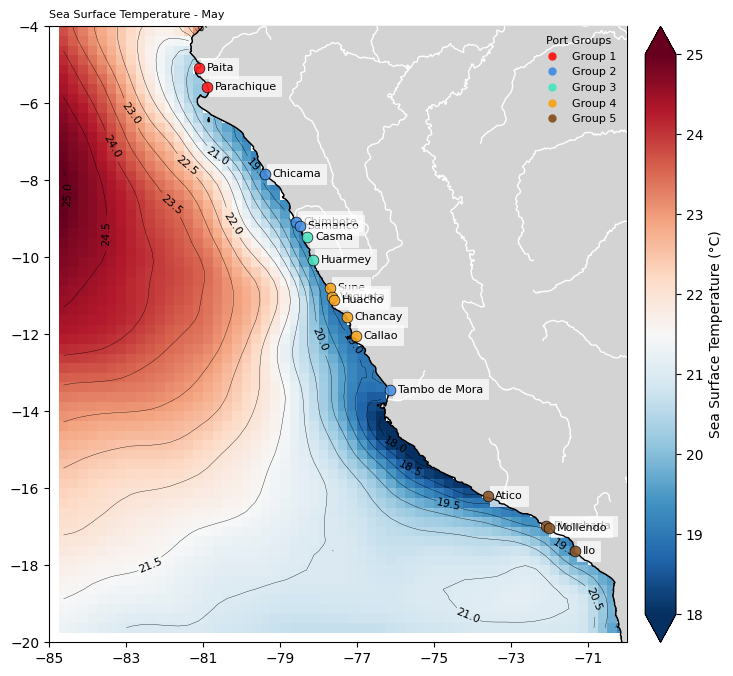

In [6]:
from plot_may_sst import plot_may_sst


fig = plot_may_sst(lon, lat, sst, vmin=18, vmax=25)
plt.show()

# Optional: save the figure
fig.savefig('../docs/figs/oisstv2/sst_may.png', dpi=300, bbox_inches='tight')
fig.savefig('../docs/figs/oisstv2/sst_may.pdf', bbox_inches='tight')

In [17]:
## Calculo de gradiente 

sst_gradient = []
for i in range(12):
    sst_month = sst.isel(time=i)

    dSST_dlat, dSST_dlon = np.gradient(sst_month, lat, lon, axis=(0, 1))
    gradient_magnitude = np.sqrt(dSST_dlat**2 + dSST_dlon**2)
    gradient_magnitude = np.sqrt(dSST_dlon**2)

    sst_gradient.append(gradient_magnitude)

sst_gradient_ds = xr.DataArray(np.array(sst_gradient), dims=['time', 'lat', 'lon'], 
                               coords={'time': ds_climatology['time'], 'lat': lat, 'lon': lon},
                               name="sst_gradient")

threshold = np.nanpercentile(sst_gradient_ds, 90)
upwelling_mask = sst_gradient_ds.where(sst_gradient_ds > threshold)

levels = np.linspace(np.nanmin(sst_gradient_ds), np.nanmax(sst_gradient_ds), 20)
closest_level = min(levels, key=lambda x: abs(x - threshold))


In [18]:
# gradiente para todos los meses
fig = plt.figure(figsize=(16, 10))

axes_locs = [
    [0.01, 0.69, 0.2, 0.27], [0.25, 0.69, 0.2, 0.27], [0.5, 0.69, 0.2, 0.27], [0.75, 0.69, 0.2, 0.27],
    [0.01, 0.37, 0.2, 0.27], [0.25, 0.37, 0.2, 0.27], [0.5, 0.37, 0.2, 0.27], [0.75, 0.37, 0.2, 0.27],
    [0.01, 0.05, 0.2, 0.27], [0.25, 0.05, 0.2, 0.27], [0.5, 0.05, 0.2, 0.27], [0.75, 0.05, 0.2, 0.27]
]

cmap = cmocean.cm.amp
axes = []
for i in range(12):
    ax = plt.axes(axes_locs[i], projection=ccrs.PlateCarree())
    axes.append(ax)

    im = ax.pcolormesh(lon, lat, upwelling_mask.isel(time=i), cmap=cmap, transform=ccrs.PlateCarree())

    contour = ax.contour(lon, lat, 
                      sst_gradient_ds.isel(time=i), levels=[closest_level], colors="black", linewidths=1, 
                      transform=ccrs.PlateCarree())
    ax.clabel(contour, inline=True, fontsize=8, fmt="%.2f")

    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_extent([lon.min().values, lon.max().values, lat.min().values, lat.max().values], crs=ccrs.PlateCarree())

    if df_ports['caleta'].isin(port_list_original_name).any():

        ax.scatter(df_ports.loc[df_ports['caleta'].isin(port_list_original_name), 'lon_decimal_corrected'], 
                   df_ports.loc[df_ports['caleta'].isin(port_list_original_name), 'lat_decimal_corrected'], 
            color='blue', edgecolor='black', s=40, alpha=0.9,
            linewidths=0.5, 
            transform=ccrs.PlateCarree())

    for _, row in df_ports[df_ports['caleta'].isin(port_list_original_name)].iterrows():
        ax.text(row['lon_decimal_corrected']+0.5, row['lat_decimal_corrected'], row['caleta'], 
                fontsize=6, color='black', transform=ccrs.PlateCarree(),
                ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.25, edgecolor='none'))    
        
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.set_title(calendar.month_abbr[i + 1], fontsize=10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())


ax_cbar = plt.axes([0.97, 0.05, 0.01, 0.9])
cbar = fig.colorbar(im, cax=ax_cbar, orientation="vertical", extend='both')
cbar.set_label("SST Gradient Magnitude (°C/deg)")
fig.savefig('../docs/figs/sst_gradient_climatology_monthly_1990_2020.png', dpi=300, bbox_inches='tight')
fig.savefig('../docs/figs/sst_gradient_climatology_monthly_1990_2020.pdf', bbox_inches='tight')
plt.close()

## SST en las ventanas de pesca

In [19]:
def extraer_meses(ventana):
    inicio_mes = int(ventana["inicio"].split("-")[0])
    fin_mes = int(ventana["fin"].split("-")[0])

    if inicio_mes <= fin_mes:
        return list(range(inicio_mes, fin_mes + 1))
    else:
        return list(range(inicio_mes, 13)) + list(range(1, fin_mes + 1))
    

def calcular_gradiente(sst_media):
    dSST_dlat, dSST_dlon = np.gradient(sst_media, lat, lon, axis=(0, 1))
    return np.sqrt(dSST_dlat**2 + dSST_dlon**2)

In [20]:
ventanas = {
    "invierno": {"inicio": "04-01", "fin": "06-30"},
    "verano": {"inicio": "10-01", "fin": "01-31"},
}

meses_verano = extraer_meses(ventanas["verano"])
meses_invierno = extraer_meses(ventanas["invierno"])

sst_verano = sst.sel(time=sst['time'].dt.month.isin(meses_verano)).mean(dim='time')
sst_invierno = sst.sel(time=sst['time'].dt.month.isin(meses_invierno)).mean(dim='time')

sst_gradiente_verano = calcular_gradiente(sst_verano)
sst_gradiente_invierno = calcular_gradiente(sst_invierno)

threshold_pesca = np.nanpercentile([sst_gradiente_verano, sst_gradiente_invierno], 80)
upwelling_mask_pesca_verano = xr.where(sst_gradiente_verano > threshold_pesca, sst_gradiente_verano, np.nan)
upwelling_mask_pesca_invierno = xr.where(sst_gradiente_invierno > threshold_pesca, sst_gradiente_invierno, np.nan)

In [21]:
# exporto mascaras de sst de invierno y verano
upwelling_mask_pesca_invierno_da = xr.DataArray(
    upwelling_mask_pesca_invierno,
    dims=["lat", "lon"],
    coords={"lat": lat, "lon": lon},
    name="upwelling_mask_pesca_invierno"
)

upwelling_mask_pesca_invierno_da.to_netcdf("../data/ocean_data_sst/processed/upwelling_mask_pesca_invierno.nc")

upwelling_mask_pesca_verano_da = xr.DataArray(
    upwelling_mask_pesca_verano,
    dims=["lat", "lon"],
    coords={"lat": lat, "lon": lon},
    name="upwelling_mask_pesca_verano"
)

upwelling_mask_pesca_verano_da.to_netcdf("../data/ocean_data_sst/processed/upwelling_mask_pesca_verano.nc")


In [22]:
axes_locs = [
    [0.05, 0.50, 0.4, 0.4], [0.55, 0.50, 0.4, 0.4],  # SST Media (Verano, Invierno)
    [0.05, 0.05, 0.4, 0.4], [0.55, 0.05, 0.4, 0.4]   # Gradiente de SST (Verano, Invierno)
]

fig = plt.figure(figsize=(10, 10))

titles = ["SST Octubre - Enero", "SST Abril - Junio", "Gradiente SST Octubre - Enero", "Gradiente SST Abril - Junio"]
datasets = [sst_verano, sst_invierno, sst_gradiente_verano, sst_gradiente_invierno]
datasets_masked = [sst_verano, sst_invierno, upwelling_mask_pesca_verano, upwelling_mask_pesca_invierno]

cmaps = [cmocean.cm.thermal, cmocean.cm.thermal, cmocean.cm.amp, cmocean.cm.amp]

vmin_sst, vmax_sst = np.nanmin([sst_verano.min(), sst_invierno.min()]), np.nanmax([sst_verano.max(), sst_invierno.max()])
vmin_grad, vmax_grad = np.nanmin([np.nanmin(sst_gradiente_verano), np.nanmin(sst_gradiente_invierno)]), np.nanmax([np.nanmax(sst_gradiente_verano), np.nanmax(sst_gradiente_invierno)])


axes = []
ims = []  # Guardar imágenes para asociarlas a las barras de color

for i in range(4):
    ax = plt.axes(axes_locs[i], projection=ccrs.PlateCarree())
    axes.append(ax)

    if i < 2:
        im = ax.pcolormesh(lon, lat, datasets_masked[i], cmap=cmaps[i], transform=ccrs.PlateCarree(), vmin=vmin_sst, vmax=vmax_sst)

        levels = np.arange(np.floor(vmin), np.ceil(vmax) + 0.5, 0.5)

        contours = ax.contour(lon, lat, datasets_masked[i], levels=levels, colors='k', linewidths=0.25, transform=ccrs.PlateCarree())
        ax.clabel(contours, inline=True, fontsize=6, fmt="%.1f")

    else:
        im = ax.pcolormesh(lon, lat, datasets_masked[i], cmap=cmaps[i], transform=ccrs.PlateCarree(), vmin=vmin_grad, vmax=vmax_grad)
        
        contour = ax.contour(lon, lat, datasets[i], levels=[threshold_pesca], colors="black", linewidths=1, transform=ccrs.PlateCarree())
        ax.clabel(contour, inline=True, fontsize=8, fmt="%.1f")

    ims.append(im)

    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_extent([lon.min().values, lon.max().values, lat.min().values, lat.max().values], crs=ccrs.PlateCarree())
    ax.set_title(titles[i], fontsize=10)

    if df_ports['caleta'].isin(port_list_original_name).any():
        ax.scatter(df_ports.loc[df_ports['caleta'].isin(port_list_original_name), 'lon_decimal_corrected'], 
                   df_ports.loc[df_ports['caleta'].isin(port_list_original_name), 'lat_decimal_corrected'], 
                   color='blue', edgecolor='black', s=40, alpha=0.9, linewidths=0.5, transform=ccrs.PlateCarree())

    for _, row in df_ports[df_ports['caleta'].isin(port_list_original_name)].iterrows():
        ax.text(row['lon_decimal_corrected'] + 0.5, row['lat_decimal_corrected'], row['caleta'], 
                fontsize=6, color='black', transform=ccrs.PlateCarree(),
                ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.25, edgecolor='none'))

    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())

cbar_ax_sst = fig.add_axes([0.98, 0.5, 0.015, 0.4])
fig.colorbar(ims[0], cax=cbar_ax_sst, orientation="vertical", extend='both').set_label("SST (°C)")

cbar_ax_grad = fig.add_axes([0.98, 0.05, 0.015, 0.4])
fig.colorbar(ims[2], cax=cbar_ax_grad, orientation="vertical", extend='both').set_label("Gradiente de SST (°C/deg)")

fig.savefig("../docs/figs/sst_media_gradiente_temporadas_pesca.png", dpi=300, bbox_inches='tight')
fig.savefig("../docs/figs/sst_media_gradiente_temporadas_pesca.pdf", bbox_inches='tight')
plt.close()

In [23]:
image_filenames = [
    '../docs/figs/sst_climatology_monthly_1990_2020.png',
    '../docs/figs/sst_climatology_monthly_1990_2020.pdf',
    '../docs/figs/sst_gradient_climatology_monthly_1990_2020.png',
    '../docs/figs/sst_gradient_climatology_monthly_1990_2020.pdf',
    '../docs/figs/sst_media_gradiente_temporadas_pesca.png',
    '../docs/figs/sst_media_gradiente_temporadas_pesca.pdf'
]

for filename in image_filenames:
    print(filename)

../docs/figs/sst_climatology_monthly_1990_2020.png
../docs/figs/sst_climatology_monthly_1990_2020.pdf
../docs/figs/sst_gradient_climatology_monthly_1990_2020.png
../docs/figs/sst_gradient_climatology_monthly_1990_2020.pdf
../docs/figs/sst_media_gradiente_temporadas_pesca.png
../docs/figs/sst_media_gradiente_temporadas_pesca.pdf
